![](title-slide.png)

![](complexity-theory.png)

![](solve-problem-on-qc.png)

![](solve-problem-on-qc-2.png)

![](utility-paper.png)

In [ ]:
pip install qiskit

# Quantum Circuits

In [1]:
from qiskit import QuantumCircuit

# Initialize quantum circuit
bell = QuantumCircuit(2)

# Apply gates
bell.h(0)
bell.cx(0,1)

# Measure qubits
bell.measure_all()

# Visualise circuit
print(bell)

        ┌───┐      ░ ┌─┐   
   q_0: ┤ H ├──■───░─┤M├───
        └───┘┌─┴─┐ ░ └╥┘┌─┐
   q_1: ─────┤ X ├─░──╫─┤M├
             └───┘ ░  ║ └╥┘
meas: 2/══════════════╩══╩═
                      0  1 


don't know what a bell state is? 
https://learn.qiskit.org/course/ch-gates/multiple-qubits-and-entangled-states

In [3]:
# custom rotations

import numpy as np

circuit = QuantumCircuit(1)
circuit.u(np.pi/2,np.pi/2,np.pi/2,0)

print(circuit)

   ┌────────────────┐
q: ┤ U(π/2,π/2,π/2) ├
   └────────────────┘


# Parameterised Circuits - great for variational algorithms!

don't know what a variational algorithm is? check out this new course (and please give us feedback!) https://qiskit.org/learn/course/algorithm-design/

In [4]:
from qiskit.circuit import Parameter

# Define a variable theta to be a parameter with name 'theta'
theta = Parameter('theta')

# Initialize a quantum circuit with one qubit
quantum_circuit = QuantumCircuit(1)

# Add a parametrized RX rotation on the qubit
quantum_circuit.rx(theta, 0)

print(quantum_circuit)

   ┌───────────┐
q: ┤ Rx(theta) ├
   └───────────┘


In [5]:
# Bind parameter values

# Set the value of the parameter
theta_value = np.pi

# Bind the value to the parametrized circuit
qc = quantum_circuit.bind_parameters({theta: theta_value})

print(quantum_circuit)

   ┌───────────┐
q: ┤ Rx(theta) ├
   └───────────┘


# Dynamic Circuits - new!

- if/else statements
- while loops
- for loops

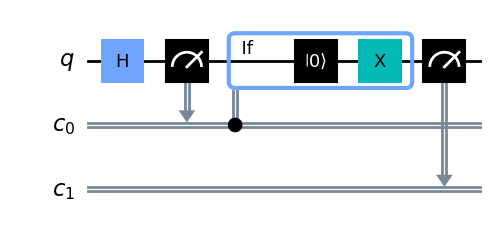

In [2]:
qc = QuantumCircuit(1, 2)
qc.h(0)  
qc.measure(0, 0)

# if q0 == 1, reset and flip it
with qc.if_test((0, True)):
    qc.reset(0)
    qc.x(0)
    
qc.measure(0, 1)

qc.draw(output="mpl")

# results: {'00': 0.5, '11': 0.5}

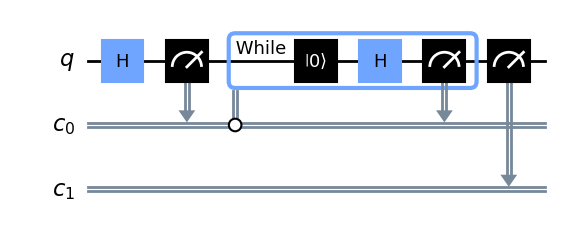

In [4]:
# Repeat instructions until success with while loop

qc = QuantumCircuit(1, 2)
qc.h(0)
qc.measure(0, 0)

# as long as q0 == 0, reset, add h and measure again until q0 == 1
with qc.while_loop((0, False)):
    qc.reset(0)
    qc.h(0)
    qc.measure(0, 0)
qc.measure(0, 1)

qc.draw(output="mpl")

# results: {'11': 1}

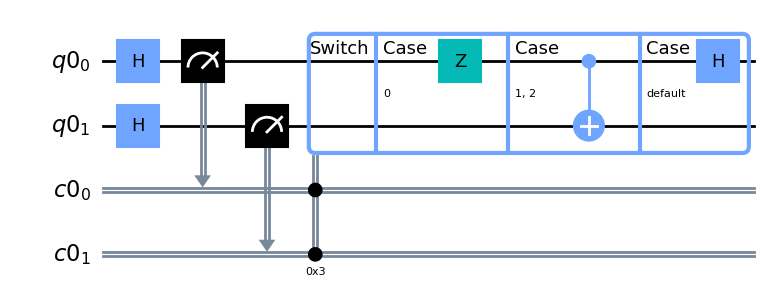

In [5]:
from qiskit import QuantumRegister, ClassicalRegister

qreg = QuantumRegister(2)
creg = ClassicalRegister(2)
qc = QuantumCircuit(qreg, creg)
qc.h([0, 1])
qc.measure([0, 1], [0, 1])

with qc.switch(creg) as case:
    # if '00' is measured, add a Z gate
    with case(0):
        qc.z(0)
    # if '01' or '10' is measured, and a CNOT
    with case(1, 2):
        qc.cx(0, 1)
    # for any other measurement, add an H gate
    with case(case.DEFAULT):
        qc.h(0)

qc.draw(output="mpl")

# Primitives

An **Estimator Primitive** computes expectation values of observables with respect to states prepared by quantum circuits. Users generally specify a list of circuits, observables, and possibly some additional configuration, with which the program can efficiently evaluate expectation values and variances.

A **Sampler Primitive** calculates probabilities or quasi-probabilities of bitstrings from quantum circuits. Quasi-probabilities are similar to regular probabilities except they may include negative values, which can occur when using certain error mitigation techniques.

# Sampler

A **Sampler Primitive** calculates probabilities or quasi-probabilities of bitstrings from quantum circuits. Quasi-probabilities are similar to regular probabilities except they may include negative values, which can occur when using certain error mitigation techniques.

### Let's sample a bell state...

In [2]:
from qiskit.primitives import Sampler

# initialise Sampler primitive (built-in qsikit simulator)
sampler = Sampler()

# Run the circuit
job = sampler.run(bell) # use bell state circuit from earlier

# get result distribution
quasi_dist = job.result().quasi_dists[0]

print(quasi_dist)

{0: 0.4999999999999999, 3: 0.4999999999999999}


### Now let's visualise the results...

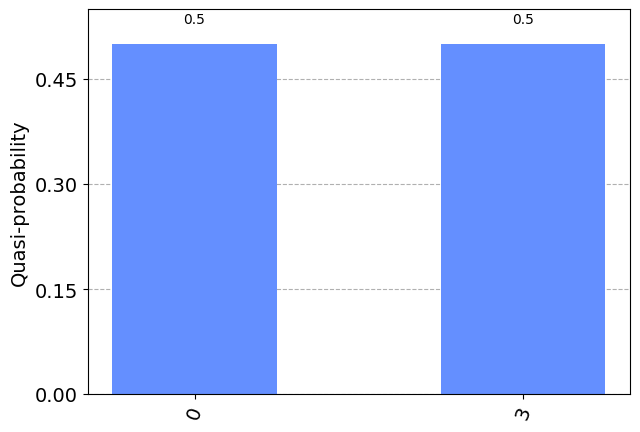

In [3]:
from qiskit.visualization import plot_histogram # note: need matplotlib installed

data = quasi_dist

plot_histogram(data)

### Now let's use a real device...

In [5]:
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler # note: need qiskit_ibm_runtime installed

# Get the API token in https://quantum-computing.ibm.com/account
service = QiskitRuntimeService(channel="ibm_quantum", 
                               token="YOUR_IBM_QUANTUM_TOKEN")
backend = service.backend("ibm_perth")

# initialise the IBM Qiskit Runtime Sampler
sampler = Sampler(session=backend)

# Run the circuit
job = sampler.run(bell) # use the bell state circuit from earlier

# get result distribution
quasi_dist_real = job.result().quasi_dists[0]

print(quasi_dist_real)

{0: 0.5208551245137784, 1: 0.003451778431075682, 2: -0.013191287785912545, 3: 0.48888438484105845}


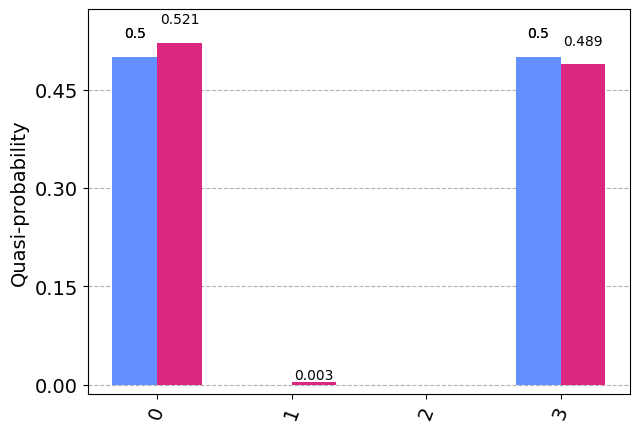

In [6]:
data = [quasi_dist, quasi_dist_real]

plot_histogram(data)

# Estimator

An **Estimator Primitive** computes expectation values of observables with respect to states prepared by quantum circuits. Users generally specify a list of circuits, observables, and possibly some additional configuration, with which the program can efficiently evaluate expectation values and variances.

### Let's estimate the ground state energy of an H2 molecule...

In [7]:
from qiskit.primitives import Estimator
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import TwoLocal
from qiskit.algorithms.optimizers import SLSQP #note: algorithms moving to new package
from qiskit.algorithms.minimum_eigensolvers import VQE

# initialise Estimator primitive (built-in qsikit simulator)
estimator = Estimator()

# Express H2 molecule Hamiltonian as an operator
H2_operator = SparsePauliOp.from_list([
    ("II", -1.052373245772859),
    ("IZ", 0.39793742484318045),
    ("ZI", -0.39793742484318045),
    ("ZZ", -0.01128010425623538),
    ("XX", 0.18093119978423156)
])

# initialise trial state and optimiser
ansatz = TwoLocal(num_qubits=2, rotation_blocks="ry", 
                  entanglement_blocks="cz")
optimizer = SLSQP(maxiter=100)

# run VQE algorithm, using the Estimator primitive
vqe = VQE(estimator, ansatz, optimizer)
result = vqe.compute_minimum_eigenvalue(operator=H2_operator)

print(result.eigenvalue)

-1.8572750285720285


### Now let's use a real device...

In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService, Estimator
from qiskit.circuit.library import TwoLocal
from qiskit.algorithms.optimizers import SLSQP
from qiskit.algorithms.minimum_eigensolvers import VQE

# Get the API token in https://quantum-computing.ibm.com/account
service = QiskitRuntimeService(channel="ibm_quantum", 
                               token="YOUR_IBM_QUANTUM_TOKEN")
backend = service.backend("ibm_perth")

# initialise Estimator primitive from Qiskit Runtime
estimator = Estimator(session=backend)

In [ ]:
#Everything else is the same from here..

# Express H2 molecule Hamiltonian as an operator
H2_operator = SparsePauliOp.from_list([
    ("II", -1.052373245772859),
    ("IZ", 0.39793742484318045),
    ("ZI", -0.39793742484318045),
    ("ZZ", -0.01128010425623538),
    ("XX", 0.18093119978423156)
])

# initialise trial state and optimiser
ansatz = TwoLocal(num_qubits=2, rotation_blocks="ry", 
                  entanglement_blocks="cz")
optimizer = SLSQP(maxiter=100)

# run VQE algorithm, using the Estimator primitive
vqe = VQE(estimator, ansatz, optimizer)
result = vqe.compute_minimum_eigenvalue(operator=H2_operator)

print(result.eigenvalue)

# What about other hardware providers?

In [ ]:
from qiskit_ionq import IonQProvider
from qiskit.primitives import BackendSampler

# connect to IonQ and select backend
provider = IonQProvider("MY_IONQ_TOKEN")
backend = provider.get_backend("ionq_qpu")

# initialise Sampler primitive using Qiskit wrapper for ionq backend
sampler = BackendSampler(backend)

# Run the circuit and get result distribution
job = sampler.run(bell) # use bell state circuit from earlier

# get result distribution
quasi_dist = job.result().quasi_dists[0]

print(quasi_dist)

# Qiskit Ecosystem

https://qiskit.org/ecosystem

The Ecosystem consists of projects, tools, utilities, libraries and tutorials from a broad community of developers and researchers. The goal of the Ecosystem is to celebrate, support and accelerate development of quantum technologies using Qiskit.

<!-- ![](ecosystem.png) -->
<img src="ecosystem.png"  width="600" height="300">

# Good candidates for the Qiskit Ecosystem
- projects built using qiskit
- research/side projects not suitable for integration into Qiskit itself
- projects that can be used/contributed to by the quantum open source community

![](links.png)

these slides: 

## What Next?

<font size=2>**Keep Learning**</font>  
<font size="1">YouTube: https://youtube.com/qiskit</font>  
<font size="1">Qiskit Textbook: https://qiskit.org/learn</font>  
<font size="1">Documentation: https://qiskit.org/documentation</font>  
<font size="1">Git & GitHub: https://qisk.it/github-training</font>  

<font size=2>**Keep Informed**</font>  
<font size="1">Twitter: @qiskit and @IBMResearch</font>  
<font size="1">LinkedIn: https://linkedin.com/showcase/ibm-quantum</font>  
<font size="1">Medium: https://medium.com/qiskit</font>  
<font size="1">Slack: https://ibm.co/joinqiskitslack</font>  
<font size="1">Events: https://qiskit.org/events/#follow-our-event-calendar</font>  

<font size=2>Qiskit Releases</font>  
<font size="1">latest release: https://qiskit.org/documentation/release_noted.html</font>  
<font size="1">upcoming releases: https://qisk.it/release-planning</font>  

<font size=2>**Start Contributing**</font>  
<font size="1">Join the Qsikit Ecosystem: https://qiskit.org/ecosystem</font>  
<font size="1">Contributing Guidelines: https://qiskit.org/documentation/contributing_to_qiskit.html</font>  
<font size="1">GitHub Discussions: https://github.com/qiskit/feedback/discussions</font>  

<font size=2>**Start Applying**</font>  
<font size="1">Qiskit Developer Certification: https://ibm.com/training/certification/C0010300</font>  
<font size="1">Qiskit Advocates: https://github.com/qiskit-advocate/application-guide</font>  
<font size="1">Researchers: https://quantum-computing.ibm.com/programs/researchers</font>  

<font size="1">Communication/support channels: https://qisk.it/support</font>  
<font size="1">Code of Conduct: https://qisk.it/coc</font>